In [2]:
%%capture
!pip install trl

# Implementation with TRL Example
Here’s a complete example using the TRL library (need some config to run):

In [12]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import SFTConfig, SFTTrainer
import torch

# Load dataset
dataset = load_dataset("HuggingFaceTB/smoltalk", "all")

# Training configuration
training_args = SFTConfig(
    output_dir="./sft_output",
    max_steps=1000,
    per_device_train_batch_size=4,
    learning_rate=5e-5,
    logging_steps=10,
    save_steps=100,
    eval_strategy="steps",
    eval_steps=50,
    packing=False,  
)

# Initialize trainer
trainer = SFTTrainer(
    model=model, # model id or a transformers model (e.g "facebook/opt-350m")
    processing_class=tokenizer,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
)

# Train
# trainer.train()

{'messages': [{'content': 'The function \\( g(x) \\) satisfies the functional equation\n\\[ g(x + y) = g(x) + g(y) \\]\nfor all real numbers \\( x \\) and \\( y \\), and it is given that \\( g(3) = 4 \\). Find \\( g(10) \\).', 'role': 'user'}, {'content': 'Given the functional equation and the specific value \\( g(3) = 4 \\), we can find \\( g(1) \\) by using the equation multiple times:\n\\[\ng(3) = g(2) + g(1)\n\\]\n\\[\ng(2) = g(1) + g(1) = 2g(1)\n\\]\nThus,\n\\[\n4 = 2g(1) + g(1) = 3g(1)\n\\]\n\\[\ng(1) = \\frac{4}{3}\n\\]\nNow we can find \\( g(10) \\) using \\( g(1) \\):\n\\[\ng(10) = 10g(1) = 10 \\times \\frac{4}{3} = \\frac{40}{3}\n\\]\nHence, the value of \\( g(10) \\) is \\(\\boxed{\\frac{40}{3}}\\).', 'role': 'assistant'}], 'source': 'numina-cot-100k'}


KeyError: 'question'

# Packing the Dataset

Class `SFTTrainer` hỗ trợ tính năng packing để tối ưu hiệu suất huấn luyện. Tính năng này cho phép gộp nhiều ví dụ ngắn vào cùng một chuỗi đầu vào, giúp tăng hiệu quả sử dụng GPU. Để bật tính năng này, chỉ cần đặt `packing=True` trong hàm khởi tạo `SFTConfig`.

⚠️ Khi sử dụng packed dataset kèm `max_steps`, cần lưu ý rằng số epoch thực tế có thể vượt quá kỳ vọng do cách các ví dụ được gộp lại.

Với `eval_dataset`, bạn có thể tắt tính năng packing bằng cách đặt `eval_packing=False` trong SFTConfig.

In [ ]:
# Configure packing
training_args = SFTConfig(packing=True)

trainer = SFTTrainer(model=model, train_dataset=dataset, args=training_args)

trainer.train()

Ngoài ra, bạn có thể tuỳ chỉnh cách gộp các ví dụ bằng cách cung cấp một hàm định dạng `(formatting_func)`. Điều này đặc biệt hữu ích khi dữ liệu huấn luyện có nhiều trường như cặp câu hỏi – trả lời.

In [ ]:
def formatting_func(example):
    text = f"### Question: {example['question']}\n ### Answer: {example['answer']}"
    return text


training_args = SFTConfig(packing=True)
trainer = SFTTrainer(
    "facebook/opt-350m",
    train_dataset=dataset,
    args=training_args,
    formatting_func=formatting_func,
)

# Monitoring Training Progess
## Understanding Loss Patterns

Training loss thường đi qua 3 giai đoạn:

1. Giảm mạnh ban đầu → mô hình thích nghi nhanh với phân phối dữ liệu mới

2. Ổn định dần → learning rate chậm lại, mô hình bắt đầu fine-tune sâu

3. Hội tụ → loss dao động nhẹ quanh một giá trị ổn định

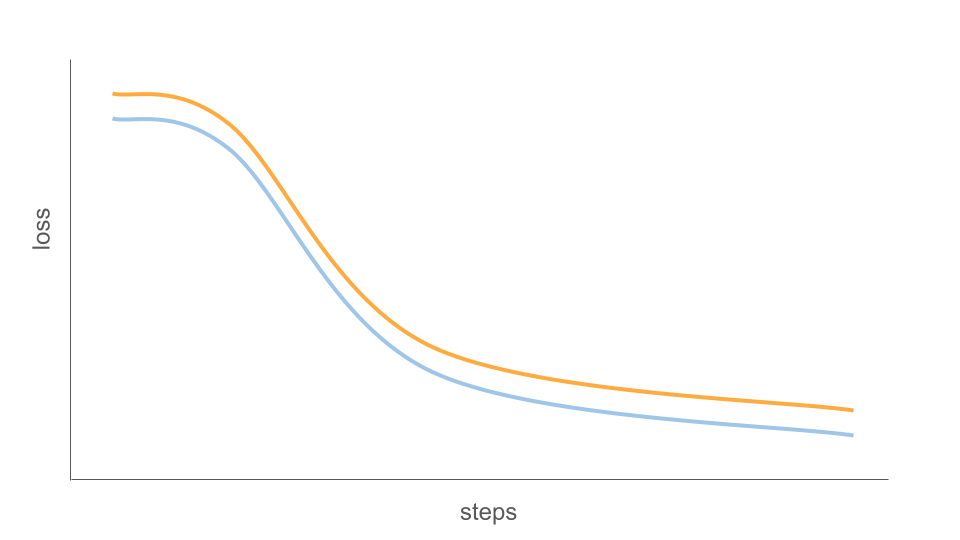

## Metrics to Monitor
Để đảm bảo huấn luyện đúng hướng, nên giám sát cả định lượng và định tính:

#### 📈 Định lượng:
- Training loss
- Validation loss
- Learning rate
- Gradient norms

#### 🔍 Định tính:
- Định dạng đầu ra (output formatting)
- Tính logic & đa dạng của câu trả lời

## Warning Signs to Watch For
1. Overfitting:

- Validation loss tăng, trong khi training loss giảm
- ✅ Cách xử lý:

  - Giảm số bước huấn luyện

  - Tăng cỡ dataset

  - Đảm bảo dữ liệu đa dạng và có chất lượng

2. Underfitting:

- Loss không cải thiện đáng kể
- ✅ Cách xử lý:

  - Tăng learning rate

  - Kiểm tra độ phức tạp của task và độ sạch của dữ liệu

  - Cân nhắc đổi model

3. Loss cực thấp (memorization):

- Dấu hiệu: Mô hình trả lời giống y training set, kém đa dạng
- ✅ Cách xử lý:

  - Kiểm tra overfitting

  - Đánh giá đầu ra thủ công
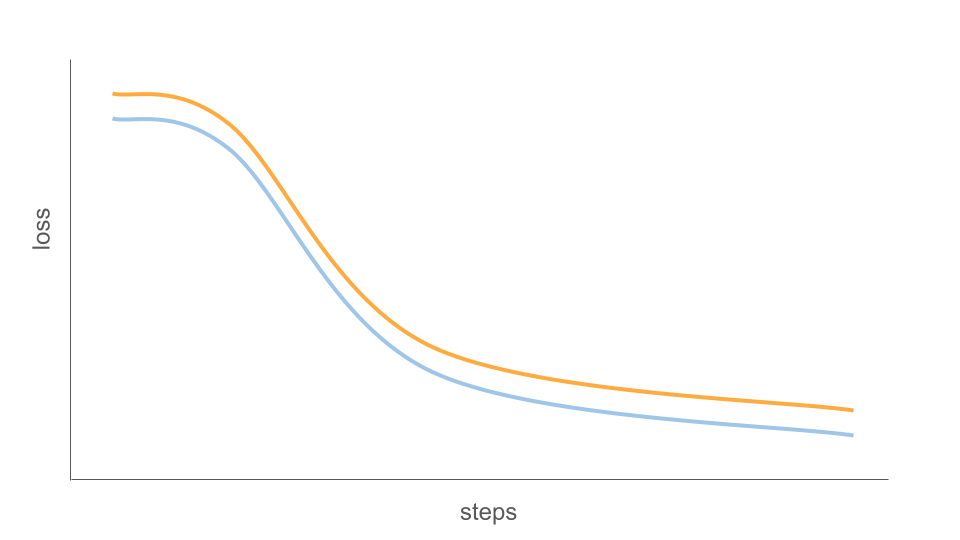